In [1]:
# Library imports
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import tools
from train import generate_graph, train

# Reproducibility

The results of this notebook are not deterministic. Therefore, the results from a previous run are loaded here. Run this cell instead of the cells in the following section ('Experiment Code') in order to generate an identical plot to the accompanying paper in the 'Plot' section at the end of the notebook.

In [2]:
# Load the previous results
with open('saved_results//hyperparameters_dimension_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Experiment Code

In [3]:
# Fix random seed for reproducibility
np.random.seed(628496)

# Stop on errors
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# Generate the synthetic data for 120 days
edges_by_day, last_day, raw_accounts = \
    tools.simulate_many_nodes(
        total_days=120
    )

# Count the number of generated edges
count_edges = sum(len(day) for day in edges_by_day.values())
print(f'There were {count_edges} edges generated.')

There were 73 edges generated.


In [5]:
results = {}
repeats = 4

for log_node_dimension in tqdm(range(2, 24)):
    # Calculate the next node dimension to test
    node_dimension = int(1.4 ** log_node_dimension)

    # Repeat a number of times to reduce variability in the results
    times = 0
    log_likelihoods = 0
    for repeat in range(repeats):
        # Start recording the time
        start_time = time.time()

        # Create a graph object
        graph = generate_graph(
            raw_accounts=raw_accounts,
            edges_by_day=edges_by_day,
            last_day=last_day,
            node_dimension=node_dimension
        )

        # Train
        probabilities = train(
            graph, edges_by_day, last_day, iterations=50,
            plot_log_likelihood=False, use_tqdm=False,
            spontaneous_learning_startpoint=0
            )

        # Stop the timer
        end_time = time.time()

        # Add the results to the running total for this number of days
        times += (end_time - start_time) / 60
        log_likelihoods += probabilities[-1]

    # Calculate the average results for this number of days
    results[node_dimension] = {
        'time_taken': times / repeats,
        'log_likelihood': log_likelihoods / repeats
    }

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [1:05:48<00:00, 179.46s/it]


In [6]:
# Save the results
with open('saved_results//hyperparameters_dimension_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Plot

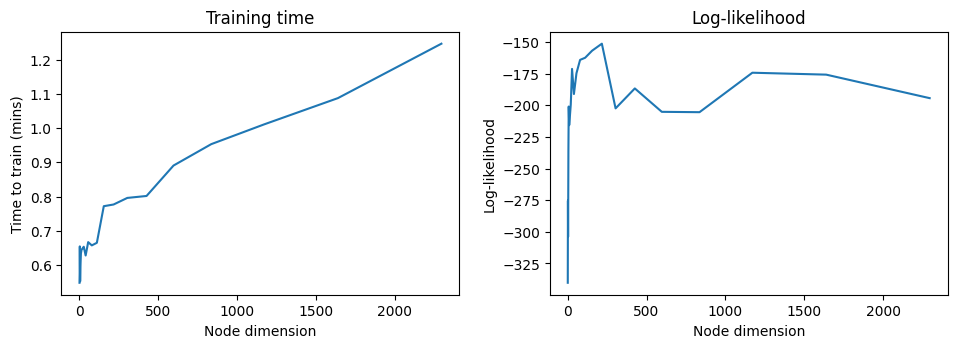

In [7]:
# Create the x-axis data
node_dimensions = np.array(list(node_dimension for node_dimension in results.keys()))
node_dimensions.sort()

# Create the subplots
fig, axes = plt.subplots(1, 2)

fig.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(3)

# Create the y-axis data for the time taken
times = np.array([results[node_dimension]['time_taken'] for node_dimension in node_dimensions])

# Plot the time taken
axes[0].plot(
    node_dimensions, times
)
axes[0].set_xlabel('Node dimension')
axes[0].set_ylabel('Time to train (mins)')
axes[0].set_title('Training time')

# Create the y-axis data for the log-likelihood
log_likelihoods = np.array([results[node_dimension]['log_likelihood'] for node_dimension in node_dimensions])

# Plot the log-likelihood
axes[1].plot(
    node_dimensions, log_likelihoods
)

axes[1].set_xlabel('Node dimension')
axes[1].set_ylabel('Log-likelihood')
axes[1].set_title('Log-likelihood')

plt.show()